In [1]:
import pickle
from collections import Counter, defaultdict

import networkx as nx
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import numpy as np
import networkit as nk
import leidenalg as la
import igraph as ig

In [2]:
with open("data/dictionary.pickle", "rb") as f:
    G = pickle.load(f)

In [4]:
print("Number of nodes:", len(G.nodes))
print("Number of edges:", len(G.edges))

Number of nodes: 102217
Number of edges: 1704423


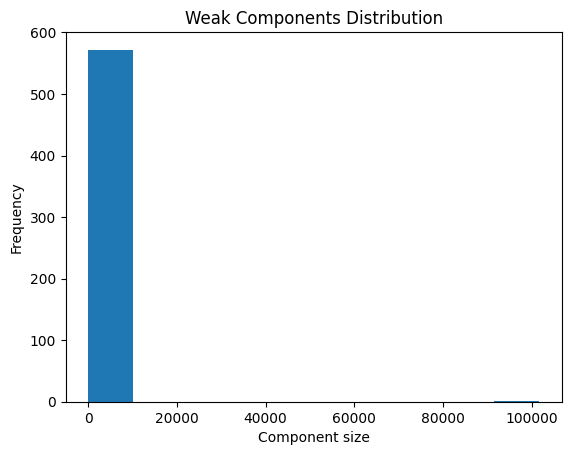

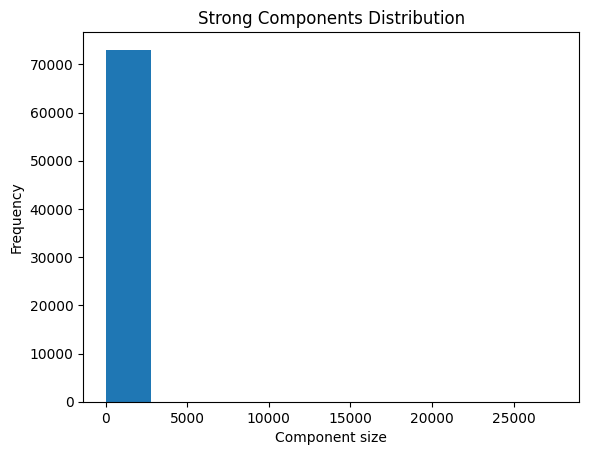

In [18]:
weak_component_sizes = [len(c) for c in nx.weakly_connected_components(G)]
strong_component_sizes = [len(c) for c in nx.strongly_connected_components(G)]

plt.hist(sorted(weak_component_sizes))

plt.xlabel("Component size")
plt.ylabel("Frequency")
plt.title("Weak Components Distribution")

plt.show()

plt.hist(sorted(strong_component_sizes))

plt.xlabel("Component size")
plt.ylabel("Frequency")
plt.title("Strong Components Distribution")

plt.show()

In [44]:
def nx_to_csr(G):
    # Ensure nodes are 0..n-1 integer labels
    mapping = {node: i for i, node in enumerate(G.nodes())}
    G = nx.relabel_nodes(G, mapping, copy=True)

    rows = []
    cols = []
    for u, v in G.edges():
        rows.append(u)
        cols.append(v)

    data = np.ones(len(rows), dtype=np.float32)
    A = sp.csr_matrix((data, (rows, cols)), shape=(G.number_of_nodes(), G.number_of_nodes()))
    return A, mapping

A, mapping = nx_to_csr(G)
inv_mapping = {i: node for node, i in mapping.items()}

def eigenvector_centrality_csr(A, tol=1e-6, maxiter=500):
    # Compute leading eigenpair of adjacency matrix
    _, vecs = spla.eigsh(A, k=1, which="LA", tol=tol, maxiter=maxiter)
    v = np.abs(vecs[:, 0])
    v /= v.sum()
    return v

def katz_centrality_csr(A, alpha=0.001, beta=1.0, tol=1e-6, maxiter=500):
    n = A.shape[0]
    x = np.ones(n, dtype=np.float32)
    ones = np.ones(n, dtype=np.float32)
    
    for _ in range(maxiter):
        x_new = alpha * (A @ x) + beta * ones
        if np.linalg.norm(x_new - x, ord=1) < tol:
            break
        x = x_new
    
    return x / x.sum()

def betweenness_networkit(G):
    G_nk = nk.nxadapter.nx2nk(G)
    bc = nk.centrality.Betweenness(G_nk, normalized=True)
    bc.run()
    return bc.scores()

def top_bottom_scores(scores, inv_mapping, k=4):
    # scores is a numpy array, size n
    idx = np.argsort(scores)            # sorted from smallest to largest
    bottom_idx = idx[:k]                # smallest k
    top_idx = idx[-k:][::-1]            # largest k, reversed to descending

    top = [(inv_mapping[i], scores[i]) for i in top_idx]
    bottom = [(inv_mapping[i], scores[i]) for i in bottom_idx]

    return top, bottom

In [ ]:
eig = eigenvector_centrality_csr(A)
print(top_bottom_scores(eig, inv_mapping))

katz = katz_centrality_csr(A)
print(top_bottom_scores(katz, inv_mapping))

betweenness = betweenness_networkit(G)
print(top_bottom_scores(betweenness, inv_mapping))

([('set', np.float32(0.0004388549)), ('run', np.float32(0.00041846122)), ('take', np.float32(0.00041152816)), ('turn', np.float32(0.0003980976))], [('zymose', np.float32(0.0)), ('prestigiation', np.float32(0.0)), ('surceaseance', np.float32(0.0)), ('loudful', np.float32(0.0))])
([('set', np.float32(1.7745435e-05)), ('run', np.float32(1.6957863e-05)), ('turn', np.float32(1.6621218e-05)), ('take', np.float32(1.6354397e-05))], [('lethy', np.float32(9.6004e-06)), ('insomnolence', np.float32(9.6004e-06)), ('halp', np.float32(9.6004e-06)), ('confus', np.float32(9.6004e-06))])
([('a', 0.02968115993505074), ('of', 0.025086603735865583), ('to', 0.02088582978712021), ('see', 0.011530321549028291)], [('praeterist', 0.0), ('everichon', 0.0), ('romic', 0.0), ('gaper', 0.0)])


In [50]:
in_degrees = sorted(G.in_degree(), key=lambda x: x[1], reverse=True)
print(in_degrees[:4], in_degrees[-4:])

out_degrees = sorted(G.out_degree(), key=lambda x: x[1], reverse=True)
print(out_degrees[:4], out_degrees[-4:])

[('a', 59405), ('of', 57317), ('the', 52744), ('or', 45817)] [('vegetation', 0), ('pectorally', 0), ('obviation', 0), ('silkness', 0)]
[('set', 750), ('run', 674), ('turn', 645), ('take', 617)] [('indisputed', 0), ('usurpant', 0), ('restorement', 0), ('apogeal', 0)]


In [52]:
print(nx.degree_assortativity_coefficient(G))

-0.21019075057483433


In [56]:
print(nx.reciprocity(G))

0.04206350184197233


In [59]:
nx.transitivity(G)

0.2152687459921913

In [ ]:
core_nums = nx.core_number(G)
colors = [core_nums[n] for n in G.nodes()]

pos = nx.spring_layout(G)
plt.figure(figsize=(10,10))
nx.draw(G, pos, node_color=colors, cmap=plt.cm., node_size=50, with_labels=False)
plt.colorbar(label="Core number")
plt.show()

In [ ]:
if nx.is_directed(G):
    G_und = G.to_undirected()
else:
    G_und = G

k_components = list(nx.k_components(G_und))
# k_components is a list of dicts {k: [sets of nodes]}
for comp in k_components:
    for k, nodesets in comp.items():
        print(f"{len(nodesets)} {k}-components")


In [ ]:
components = list(nx.weakly_connected_components(G))

largest_cc = max(components, key=len)
G_lcc = G.subgraph(largest_cc).copy()

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Largest component size: {len(largest_cc)} ({len(largest_cc)/G.number_of_nodes():.2%} of nodes)")

Number of nodes: 102217
Largest component size: 101642 (99.44% of nodes)


In [20]:
avg_clustering = nx.average_clustering(G_lcc)  # only on giant component
print(f"Average clustering: {avg_clustering:.4f}")

KeyboardInterrupt: 

Estimated alpha = 1.4210623145090402


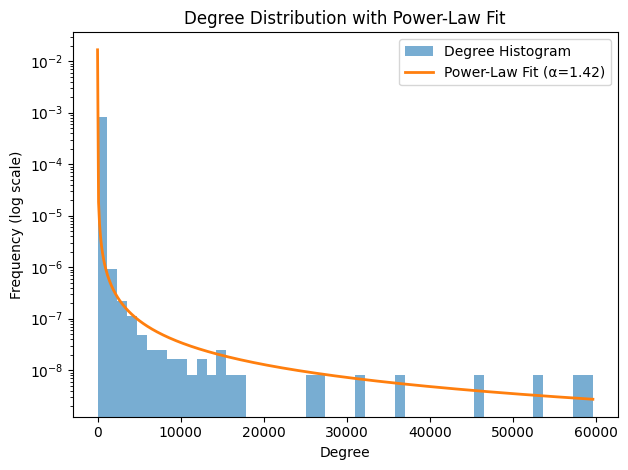

In [4]:
degrees = np.array([d for _, d in G.degree()])

xmin = 1
deg_ge_xmin = degrees[degrees >= xmin]

alpha = 1 + len(deg_ge_xmin) / np.sum(np.log(deg_ge_xmin / xmin))
print("Estimated alpha =", alpha)

# ---------------------------------------------------------
# 2. Define k-values only for k >= xmin (avoid zero!)
# ---------------------------------------------------------
k_vals = np.linspace(xmin, degrees.max(), 500)

# Power-law PDF (no zeros in denominator)
powerlaw_pdf = (k_vals / xmin) ** (-alpha)

# Normalize to match histogram's density=True scaling
powerlaw_pdf /= np.trapezoid(powerlaw_pdf, k_vals)

# ---------------------------------------------------------
# 3. Plot: exact histogram you provided + fitted curve
# ---------------------------------------------------------

# Your original histogram (unchanged)
plt.hist(degrees, bins=50, density=True, log=True,
         alpha=0.6, label="Degree Histogram")

# Add fitted power-law curve
plt.plot(k_vals, powerlaw_pdf, linewidth=2,
         label=f"Power-Law Fit (α={alpha:.2f})")

plt.xlabel("Degree")
plt.ylabel("Frequency (log scale)")
plt.title("Degree Distribution with Power-Law Fit")
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
xmin = 1
deg_ge_xmin = degrees[degrees >= xmin].astype(float)
n = len(deg_ge_xmin)

alpha_hat = 1.0 + n / np.sum(np.log(deg_ge_xmin / xmin))
analytic_se = (alpha_hat - 1.0) / np.sqrt(n)

print(f"alpha_hat = {alpha_hat:.4f}")
print(f"analytic SE (approx) = {analytic_se:.4f}")

alpha_hat = 1.4211
analytic SE (approx) = 0.0013


In [9]:
g = ig.Graph(directed=True)
g.add_vertices(list(G.nodes()))
g.add_edges(list(G.edges()))

partition = la.find_partition(
    g,
    la.ModularityVertexPartition, 
    weights=None,
    n_iterations=-1
)
communities = partition.membership

In [15]:
np.max(np.bincount(communities))

np.int64(33285)

Text(0.5, 1.0, 'Community Size Distribution')

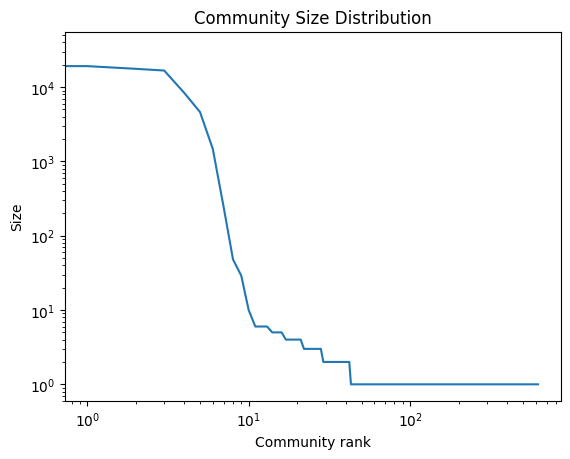

In [10]:
sizes = np.bincount(communities)
plt.loglog(sorted(sizes[sizes>0], reverse=True))
plt.xlabel("Community rank")
plt.ylabel("Size")
plt.title("Community Size Distribution")

In [16]:
def build_meta_graph(G, partition, remove_self_loops=True):
    # Convert to mapping if Leiden returned list
    if not isinstance(partition, dict):
        partition = {node: part for node, part in zip(G.nodes(), partition)}

    # Meta graph
    M = nx.DiGraph()

    # Add community nodes
    communities = set(partition.values())
    for c in communities:
        M.add_node(c, size=0)

    # Count sizes
    for node in G.nodes():
        if node in partition:
            M.nodes[partition[node]]["size"] += 1

    # Weighted edges between communities
    edge_weights = defaultdict(float)

    for u, v, data in G.edges(data=True):
        if u not in partition or v not in partition:
            continue  # skip stray nodes

        cu = partition[u]
        cv = partition[v]
        if remove_self_loops and cu == cv:
            continue

        w = data.get("weight", 1.0)
        edge_weights[(cu, cv)] += w

    # Add meta edges
    for (cu, cv), w in edge_weights.items():
        M.add_edge(cu, cv, weight=w)

    return M

In [21]:
M = build_meta_graph(G, communities)
print("Communities:", len(M.nodes()))
print("Inter-community edges:", len(M.edges()))

Communities: 621
Inter-community edges: 268


In [111]:
[node for node, com in zip(G.nodes, communities) if com == 9]

['satanical',
 'erebus',
 'devilish',
 'infernal',
 'stygian',
 'lucifrian',
 'fendliche',
 'deuced',
 'hellkite',
 'hellish',
 'helly',
 'vantage game',
 'diabolic',
 'fiendish',
 'charon',
 'tartarean',
 'duse',
 'satanic',
 'tartarus',
 'styx',
 'deuse',
 'subtartarean',
 'fiendly',
 'diabolical',
 'deused',
 'hellbroth',
 'fiendlike',
 'fiendful',
 'deuce']

Active communities: 49, edges: 268


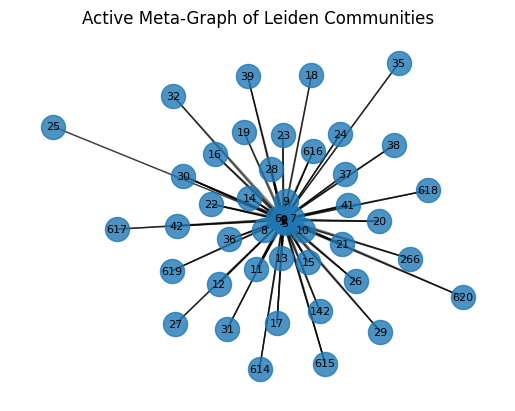

In [37]:
active_nodes = set()
for u, v in M.edges():
    active_nodes.add(u)
    active_nodes.add(v)

M_active = M.subgraph(active_nodes).copy()
print(f"Active communities: {len(M_active.nodes())}, edges: {len(M_active.edges())}")

# Spring layout
pos = nx.spring_layout(M_active, k=0.5, iterations=200)

nx.draw_networkx_nodes(M_active, pos, alpha=0.8)
nx.draw_networkx_edges(M_active, pos, alpha=0.5, arrows=False)
nx.draw_networkx_labels(M_active, pos, font_size=8)

plt.title("Active Meta-Graph of Leiden Communities")
plt.axis("off")
plt.show()

In [68]:
components = sorted(nx.strongly_connected_components(G), key=len, reverse=True)
components[1:]

[{'analcime',
  'desmine',
  'heulandite',
  'mesole',
  'stilbite',
  'thomsonite',
  'zeolite',
  'zeolitic'},
 {'albumose',
  'amphopeptone',
  'antialbumose',
  'antipeptone',
  'hemialbumose',
  'hemipeptone',
  'peptone'},
 {'pearlite',
  'pearlstone',
  'perlite',
  'perlitic',
  'spherulite',
  'spherulitic'},
 {'bote', 'firebote', 'haybote', 'hedgebote', 'housebote', 'plowbote'},
 {'fascet', 'pontee', 'ponty', 'puntel', 'puntil', 'punty'},
 {'metamer', 'metaxylene', 'orthoxylene', 'paraxylene', 'xylene', 'xylol'},
 {'cannula', 'cannular', 'cannulated', 'canula', 'canular', 'canulated'},
 {'malanders', 'mallenders', 'sallenders', 'sellanders', 'sellenders'},
 {'periagua', 'periauger', 'perogue', 'piragua', 'pirogue'},
 {'caul', 'gastrocolic', 'gastrohepatic', 'hepatogastric', 'omentum'},
 {'worble', 'wormal', 'wormil', 'wormul', 'wornil'},
 {'graphitic', 'honeystone', 'mellitate', 'mellite', 'mellitic'},
 {'demotic', 'enchorial', 'epistolographic', 'hieratic'},
 {'sheal', 'shea

In [142]:
G.remove_edges_from(nx.selfloop_edges(G))
subgraphs = nx.k_core(G, k=110)

In [143]:
print(len(subgraphs.nodes))
print(subgraphs.nodes)

1075
['corn', 'sound', 'table', 'screw', 'bar', 'horse', 'also', 'flesh', 'center', 'most', 'master', 'chase', 'rat', 'mold', 'anchor', 'fill', 'receive', 'slide', 'bed', 'right', 'matt', 'and', 'mind', 'some', 'log', 'file', 'fact', 'rest', 'country', 'middle', 'ward', 'take', 'living', 'brace', 'resolve', 'estimate', 'me', 'make', 'hard', 'gas', 'form', 'convert', 'proof', 'distinct', 'stay', 'attachment', 'movement', 'close', 'material', 'shoe', 'tooth', 'radical', 'brush', 'service', 'deal', 'utter', 'work', 'lock', 'rail', 'fig', 'below', 'opposite', 'hair', 'weigh', 'measure', 'chief', 'temper', 'degree', 'say', 'limit', 'sweet', 'bone', 'mother', 'pay', 'reference', 'game', 'experience', 'labor', 'reach', 'into', 'course', 'circle', 'same', 'business', 'slip', 'i', 'ease', 'golden', 'forward', 'board', 'oil', 'young', 'whether', 'counsel', 'death', 'only', 'rather', 'care', 'burn', 'blood', 'various', 'hour', 'find', 'were', 'train', 'capital', 'upper', 'deliver', 'fit', 'land',

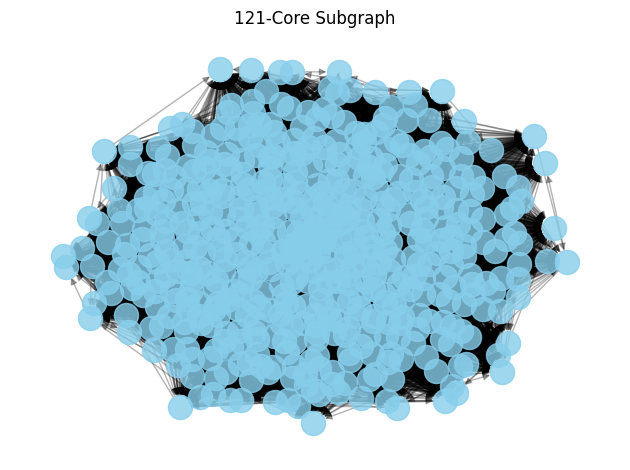

In [4]:
# Layout
pos = nx.spring_layout(subgraphs, k=0.5, iterations=200)

# Draw nodes
nx.draw_networkx_nodes(subgraphs, pos, alpha=0.8, node_color='skyblue')

# Draw edges
nx.draw_networkx_edges(subgraphs, pos, alpha=0.3)

# Optional: labels (omit for very large k-core)

plt.title("121-Core Subgraph")
plt.axis('off')
plt.tight_layout()
plt.show()

In [3]:
G.remove_edges_from(nx.selfloop_edges(G))
subgraphs = nx.k_core(G, k=120)

print(len(subgraphs.nodes))
print(subgraphs.nodes)

521
['after', 'about', 'fine', 'by', 'range', 'through', 'trust', 'also', 'blank', 'science', 'weight', 'full', 'proper', 'against', 'world', 'sy', 'ride', 'length', 'early', 'party', 'sense', 'made', 'field', 'flat', 'press', 'move', 'were', 'heat', 'great', 'keep', 'fly', '--', 'bottom', 'form', 'him', 'last', 'board', 'center', 'rock', 'principal', 'bee', 'circle', 'sir', 'leave', 'fit', 'and', 'pass', 'age', 'red', 'dress', 'compound', 'cast', 'close', 'thy', 'surface', 'she', 'water', 'bill', 'has', 'set', 'weak', 'kind', 'c', 'lose', 'bell', 'thus', 'iron', 'square', 'sign', 'waste', 'ear', 'stock', 'honor', 'lie', 'settle', 'h', 'wood', 'scale', 'you', 'double', 'fall', 'tide', 'wind', 'as', 'measure', 'mean', 'large', 'for', 'book', 'a', 'service', 'where', 'wit', 'war', 'thou', 'sometimes', 'idea', 'each', 'hold', 'paper', 'anything', 'business', 'game', 'object', 'mark', 'return', 'roll', 'cause', 'open', 'vessel', 'soft', 'single', 'order', 'sit', 'line', 'eye', 'he', 'rose'